In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [47]:
df = read_csv('PRSA_data_2010.1.1-2014.12.31.csv', index_col=0)
encoder = LabelEncoder()
df['encoded_cbwd'] = encoder.fit_transform(df['cbwd'])
df = df.drop(['cbwd'], axis=1)

df['y'] = df['pm2.5'].shift(-1)
df = df.dropna(subset=['y'])
df = df.drop(['pm2.5'], axis=1)
df

,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,encoded_cbwd,y
No,,,,,,,,,,,,
24,2010,1,1,23,-17,-5.0,1020.0,0.89,0,0,3,129.0
25,2010,1,2,0,-16,-4.0,1020.0,1.79,0,0,2,148.0
26,2010,1,2,1,-15,-4.0,1020.0,2.68,0,0,2,159.0
27,2010,1,2,2,-11,-5.0,1021.0,3.57,0,0,2,181.0
28,2010,1,2,3,-7,-5.0,1022.0,5.36,1,0,2,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,18,-22,-2.0,1033.0,226.16,0,0,1,8.0
43820,2014,12,31,19,-23,-2.0,1034.0,231.97,0,0,1,10.0
43821,2014,12,31,20,-22,-3.0,1034.0,237.78,0,0,1,10.0


In [45]:
df

,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,y,encoded_cbwd
No,,,,,,,,,,,,
24,2010,1,1,23,-17,-5.0,1020.0,0.89,0,0,129.0,3
25,2010,1,2,0,-16,-4.0,1020.0,1.79,0,0,148.0,2
26,2010,1,2,1,-15,-4.0,1020.0,2.68,0,0,159.0,2
27,2010,1,2,2,-11,-5.0,1021.0,3.57,0,0,181.0,2
28,2010,1,2,3,-7,-5.0,1022.0,5.36,1,0,138.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,18,-22,-2.0,1033.0,226.16,0,0,8.0,1
43820,2014,12,31,19,-23,-2.0,1034.0,231.97,0,0,10.0,1
43821,2014,12,31,20,-22,-3.0,1034.0,237.78,0,0,10.0,1


In [5]:
# load dataset
dataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv', index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
encoder2 = LabelEncoder()
values[:,8] = encoder2.fit_transform(values[:, 8])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0        0.0   0.000000        1.0   0.279412   
2        0.0        0.0        0.0   0.043478        1.0   0.279412   
3        0.0        0.0        0.0   0.086957        1.0   0.279412   
4        0.0        0.0        0.0   0.130435        1.0   0.279412   
5        0.0        0.0        0.0   0.173913        1.0   0.294118   

   var7(t-1)  var8(t-1)  var9(t-1)  var5(t)   var6(t)   var7(t)   var8(t)  \
1   0.131148   0.545454   0.333333      1.0  0.279412  0.114754  0.527273   
2   0.114754   0.527273   0.333333      1.0  0.279412  0.131148  0.509090   
3   0.131148   0.509090   0.333333      1.0  0.279412  0.081967  0.509090   
4   0.081967   0.509090   0.333333      1.0  0.294118  0.114754  0.490910   
5   0.114754   0.490910   0.333333      1.0  0.308824  0.147541  0.472727   

    var9(t)  var10(t)  var11(t)  var12(t)  
1  0.333333  0.007639       0.0       0.0  
2  0.333333  0.010698 

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 16) (8760,) (35063, 1, 16) (35063,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Epoch 1/50
122/122 - 5s - loss: 0.0143 - val_loss: 0.0130
Epoch 2/50
122/122 - 1s - loss: 0.0137 - val_loss: 0.0184
Epoch 3/50
122/122 - 1s - loss: 0.0137 - val_loss: 0.0130
Epoch 4/50
122/122 - 1s - loss: 0.0111 - val_loss: 0.0106
Epoch 5/50
122/122 - 1s - loss: 0.0122 - val_loss: 0.0221
Epoch 6/50
122/122 - 1s - loss: 0.0127 - val_loss: 0.0207
Epoch 7/50
122/122 - 1s - loss: 0.0106 - val_loss: 0.0217
Epoch 8/50
122/122 - 1s - loss: 0.0119 - val_loss: 0.0196
Epoch 9/50
122/122 - 1s - loss: 0.0104 - val_loss: 0.0211
Epoch 10/50
122/122 - 1s - loss: 0.0100 - val_loss: 0.0198
Epoch 11/50
122/122 - 1s - loss: 0.0096 - val_loss: 0.0235
Epoch 12/50
122/122 - 1s - loss: 0.0112 - val_loss: 0.0243
Epoch 13/50
122/122 - 1s - loss: 0.0117 - val_loss: 0.0222
Epoch 14/50
122/122 - 1s - loss: 0.0112 - val_loss: 0.0210
Epoch 15/50
122/122 - 1s - loss: 0.0098 - val_loss: 0.0222
Epoch 16/50
122/122 - 1s - loss: 0.0089 - val_loss: 0.0130
Epoch 17/50
122/122 - 1s - loss: 0.0110 - val_loss: 0.0202
Epoch 

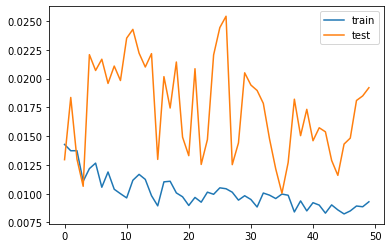

In [8]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (35063,16) (12,) (35063,16) 

In [30]:
test_X

array([[0.25      , 0.        , 0.        , ..., 0.33333334, 0.97938997,
        0.        ],
       [0.25      , 0.        , 0.        , ..., 0.33333334, 0.98626   ,
        0.        ],
       [0.25      , 0.        , 0.        , ..., 0.33333334, 0.9931301 ,
        0.        ],
       ...,
       [1.        , 1.        , 1.0000001 , ..., 0.33333334, 0.41399646,
        0.        ],
       [1.        , 1.        , 1.0000001 , ..., 0.33333334, 0.4208665 ,
        0.        ],
       [1.        , 1.        , 1.0000001 , ..., 0.33333334, 0.42621556,
        0.        ]], dtype=float32)

In [28]:
yhat.shape

(35063, 1)

In [20]:
values.shape

(43823, 17)

In [22]:
scaled.shape

(43824, 12)

In [23]:
inv_scaled = scaler.inverse_transform(scaled)

In [25]:
inv_scaled.shape

(43824, 12)

In [18]:
yhat.shape

(35063, 1)

In [17]:
test_X.shape

(35063, 16)

In [19]:
scaler

MinMaxScaler()

In [27]:
inv_yhat.shape

(35063, 16)